In [4]:
import numpy as np
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import math
import torch.nn.functional as F

In [5]:
G = nx.Graph()
blue, orange, green = '#1f77b4', '#ff7f0e', '#2ca02c'
G.add_nodes_from([
(1, {"color" : blue}),
(2, {"color" : orange}),
(3, {"color" : blue}),
(4, {"color" : green}),
])

G.add_edges_from([(1,2) ,(2,3), (1,3), (3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())


In [6]:
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


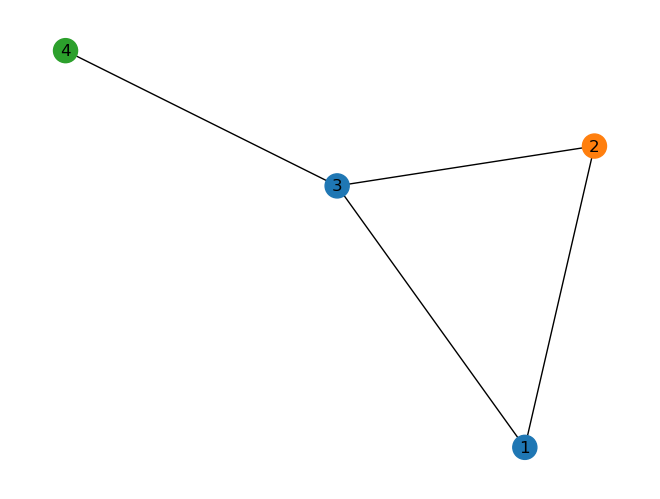

In [7]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels = True, node_color = color_map)

In [8]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in,f_out)
W_2 = np.random.rand(f_in,f_out)
h = np.dot(X,W_1) + np.dot(np.dot(A,X),W_2)


# Implementing a GNN in Pytorch from Scratch

### Defining the NodeNetwork model

In [9]:
class NodeNetwork(torch.nn.Module):
    def __init__(self,input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32,16)
        self.out_layer = torch.nn.Linear(16,2)
    def forward(self,X,A, batch_mat):
        x = F.relu(self.conv_1(X,A))
        x = F.relu(self.conv_2(x,A))
        output = global_sum_pool(x,batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output,dim=1)

### Coding the NodeNetwork's graph convolution layer

In [10]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(
                out_channels, dtype=torch.float32))
        
    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

In [11]:
#Try out the BasicGraphConvolutionLayer
print('X.shape:', X.shape) 
print('A.shape:', A.shape)
basiclayer = BasicGraphConvolutionLayer(3, 8)
out = basiclayer(X=torch.tensor(X, dtype=torch.float32),
                 A=torch.tensor(A, dtype=torch.float32))
print('Output shape:', out.shape)

X.shape: (4, 3)
A.shape: (4, 4)
Output shape: torch.Size([4, 8])


### Adding a global pooling layer to deal with varying graph size

In [12]:
#define the global_sum_pool() function that was used in the NodeNetwork class, where 
# Global pooling layers aggregate all of a graph's node embbedings into a fixed-sized output
def global_sum_pool(X, batch_mat):
   if batch_mat is None or batch_mat.dim() == 1:
     return torch.sum(X, dim=0).unsqueeze(0)
   else:
     return torch.mm(batch_mat, X)

In [13]:
# generate this mask for graphs of sizes n1, ..., nk 
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx,start:stop] = 1
    return batch_mat


In [14]:
# batch is a list of dictionaries each containing
# the representation and label of a graph
def collate_graphs(batch):
   adj_mats = [graph['A'] for graph in batch]
   sizes = [A.size(0) for A in adj_mats]
   tot_size = sum(sizes)
   # create batch matrix
   batch_mat = get_batch_tensor(sizes)
   # combine feature matrices
   feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
   # combine labels
   labels = torch.cat([graph['y'] for graph in batch], dim=0)
   # combine adjacency matrices
   batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
   accum = 0
   for adj in adj_mats:
      g_size = adj.shape[0]
      batch_adj[accum:accum+g_size,accum:accum+g_size] = adj
      accum = accum + g_size
      repr_and_label = {'A': batch_adj,'X': feat_mats, 'y': labels,'batch': batch_mat}
   return repr_and_label


### Preparing the DataLoader

In [15]:
def get_graph_dict(G, mapping_dict):
     # Function builds dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation()
   # was introduced with the first example graph
    X = torch.from_numpy(build_graph_color_label_representation(G, mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1,0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

In [16]:
 # building 4 graphs to treat as a dataset
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict= {green:0, blue:1, orange:2}
G1 = nx.Graph()
G1.add_nodes_from([
     (1,{"color": blue}),
     (2,{"color": orange}),
     (3,{"color": blue}),
     (4,{"color": green})
])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([
    (1,{"color": green}),
    (2,{"color": green}),
    (3,{"color": orange}),
    (4,{"color": orange}),
    (5,{"color": blue})
])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([
    (1,{"color": orange}),
    (2,{"color": orange}),
    (3,{"color": green}),
    (4,{"color": green}),
    (5,{"color": blue}),
    (6,{"color":orange})
])
G3.add_edges_from([(2,3), (3,4), (3,1), (5,1), (2,5), (6,1)])
G4 = nx.Graph()
G4.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": blue}),
    (3,{"color": green})
])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph, mapping_dict) for graph in
    [G1, G2, G3, G4]]

In [17]:
from torch.utils.data import Dataset
class ExampleDataset(Dataset):
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list
    def __len__(self):
        return len(self.graphs)
    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [18]:
from torch.utils.data import DataLoader
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(
    dset, batch_size=2, shuffle=False,
    collate_fn=collate_graphs)

In [19]:
node_features = 3
net = NodeNetwork(node_features)
batch_results = []
for b in loader:
    batch_results.append(
        net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(
     G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()
G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)

# Implementing a GNN using the PyTorch Geometric Library

In [ ]:
# For all examples in this section we use the following imports.
# Note that we are using torch_geometric's DataLoader.
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
# let's load the QM9 small molecule dataset
dset = QM9('.')
len(dset)

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [5]:
# Here's how torch geometric wraps data
data = dset[0]
# can access attributes directly
data.z

tensor([6, 1, 1, 1, 1])

In [ ]:
# the atomic number of each atom can add attributes
data.new_attribute = torch.tensor([1, 2, 3])
#can move all attributes between devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

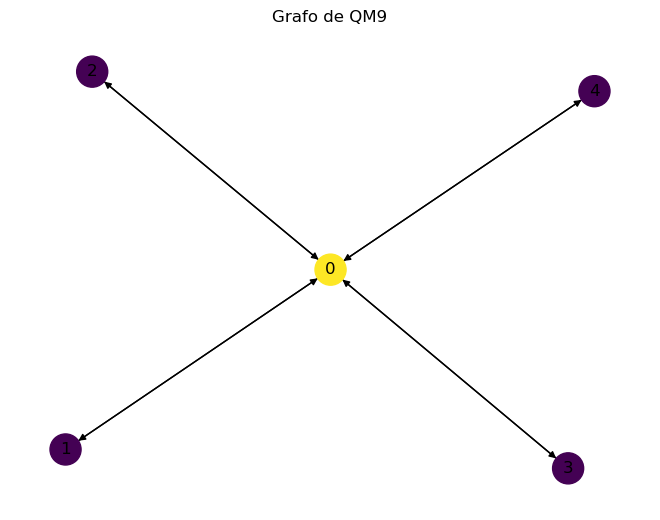

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convertimos el grafo a formato NetworkX
graph = to_networkx(data, node_attrs=['z'], edge_attrs=None)

# Configurar el layout de los nodos
pos = nx.spring_layout(graph)  # Usa un layout de resorte para la disposición de nodos

# Dibujamos el grafo
plt.figure()
nx.draw(graph, pos, with_labels=True, node_color=data.z.cpu().numpy(), cmap=plt.cm.viridis, node_size=500)
plt.title("Grafo de QM9")
plt.show()


In [26]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32,16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    def forward(self, data):
        batch, x, edge_index, edge_attr = (
            data.batch, data.x, data.edge_index, data.edge_attr)
        # First graph conv layer
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # Second graph conv layer
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [ ]:

from torch.utils.data import random_split
train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:

# initialize a network
qm9_node_feats, qm9_edge_feats = 11, 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)
# initialize an optimizer with some reasonable parameters
optimizer = torch.optim.Adam(
    net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:

for total_epochs in range(epochs):
    epoch_loss = 0      
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(
            output,batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(
            output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {total_epochs} | "
          f"epoch avg. loss: {train_avg_loss:.2f} | "
          f"validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.39 | validation avg. loss: 0.22
Epochs: 1 | epoch avg. loss: 0.13 | validation avg. loss: 0.14
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.20
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.08
Epochs: 4 | epoch avg. loss: 0.09 | validation avg. loss: 0.11
Epochs: 5 | epoch avg. loss: 0.09 | validation avg. loss: 0.10


In [ ]:

net.eval()
predictions = []
real = []
for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(
            batch.y[:,target_idx] .detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

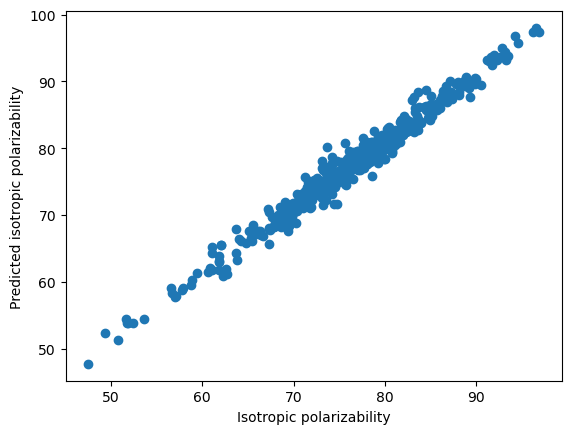

In [33]:
import matplotlib.pyplot as plt
plt.scatter(real[:500], predictions[:500])
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')